In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from citipy import citipy
import requests
import warnings
warnings.filterwarnings('ignore')

In [66]:
#flight data to dataframe
flight_data_df = pd.read_csv("flights_sample_3m.csv")

In [67]:
#COVID API
state = "ca" #Test 
url = f"https://api.covidtracking.com/v2/states/{state.lower()}/daily/simple.json"
state_data = requests.get(url).json()
state_name = state_data["data"][0]["state"]
print(state_name) 

CA


In [68]:
# Separate flight date, airline, flight number, origin city, destination city & cancelled
simplified_flight_df = flight_data_df[["FL_DATE","AIRLINE","ORIGIN_CITY","DEST_CITY","DEP_DELAY","CANCELLED"]]

In [69]:
# Creating an origin state column
simplified_flight_df["ORIGIN_STATE"] = simplified_flight_df["ORIGIN_CITY"].str.rsplit(',').str[-1]

In [70]:
# Filter the DataFrame to include only rows with positive departure delays because EARLY departures show as negative numbers 
filtered_df = simplified_flight_df[(simplified_flight_df["DEP_DELAY"] > 0)]

In [71]:
# Cancellation only dataframe
# Count the number of cancelled flights
# Not all delays result in cancellations, but all cancellations are delays 
cancelled_flights_df = simplified_flight_df[simplified_flight_df["CANCELLED"] == 1]
cancelled_flights_df

,FL_DATE,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE
14,2020-04-07,Southwest Airlines Co.,"San Jose, CA","Los Angeles, CA",NaN,1.0,CA
45,2022-01-02,Republic Airline,"Chicago, IL","Washington, DC",NaN,1.0,IL
80,2020-04-20,Southwest Airlines Co.,"Nashville, TN","Atlanta, GA",NaN,1.0,TN
191,2021-12-31,Alaska Airlines Inc.,"Washington, DC","Los Angeles, CA",NaN,1.0,DC
236,2020-04-14,Southwest Airlines Co.,"Las Vegas, NV","Houston, TX",NaN,1.0,NV
...,...,...,...,...,...,...,...
2999779,2019-06-17,PSA Airlines Inc.,"Washington, DC","Akron, OH",NaN,1.0,DC
2999865,2021-10-22,SkyWest Airlines Inc.,"Chicago, IL","Memphis, TN",NaN,1.0,IL
2999910,2020-04-08,Allegiant Air,"Punta Gorda, FL","St. Cloud, MN",NaN,1.0,FL
2999943,2020-03-30,American Airlines Inc.,"Fort Lauderdale, FL","Charlotte, NC",NaN,1.0,FL


In [72]:
#Total number delayed and cancelled flights

# Count the total number delayed and cancelled flights
num_delayed_flights = simplified_flight_df[simplified_flight_df["DEP_DELAY"] > 0].shape[0]

# Count the number of only cancelled flights
num_cancelled_flights = simplified_flight_df[simplified_flight_df["CANCELLED"] == 1].shape[0]

print("Total number of flights delayed:", num_delayed_flights)
print("Total number of flights canceled:", num_cancelled_flights)

# REMINDER: Not all delays result in cancellations, but all cancellations ar

Total number of flights delayed: 992843
Total number of flights canceled: 79140


In [73]:
# Total number delayed and cancelled flights by the Top 5 airlines overall
airline_counts = filtered_df["AIRLINE"].value_counts().head(5)
airline_counts

AIRLINE
Southwest Airlines Co.    264849
American Airlines Inc.    131490
Delta Air Lines Inc.      118515
United Air Lines Inc.      88055
SkyWest Airlines Inc.      83332
Name: count, dtype: int64

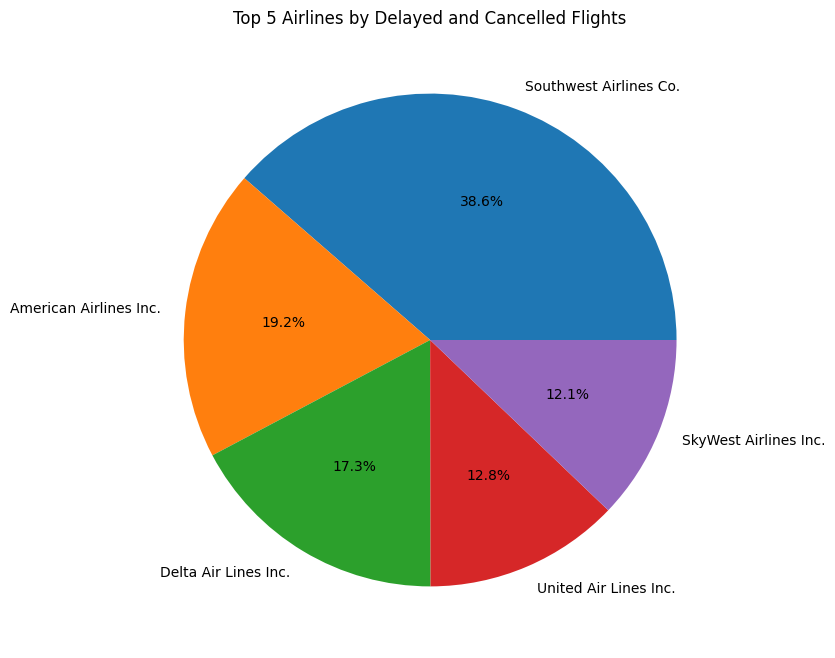

In [74]:
# Plotting a pie chart for Top 5 airlines with the most Delays and Cancelled Flights
plt.figure(figsize=(8, 8))
plt.pie(airline_counts, labels=airline_counts.index, autopct='%1.1f%%')
plt.title('Top 5 Airlines by Delayed and Cancelled Flights')
plt.show()

AIRLINE  American Airlines Inc.  Delta Air Lines Inc.  SkyWest Airlines Inc.  \
FL_DATE                                                                        
2019                      35748                 31067                  23351   
2020                      11985                 10060                   9423   
2021                      25052                 21529                  18800   
2022                      33140                 30769                  20057   
2023                      25565                 25090                  11701   

AIRLINE  Southwest Airlines Co.  United Air Lines Inc.  
FL_DATE                                                 
2019                      63531                  20643  
2020                      20445                   5737  
2021                      56826                  16172  
2022                      73257                  24899  
2023                      50790                  20604  


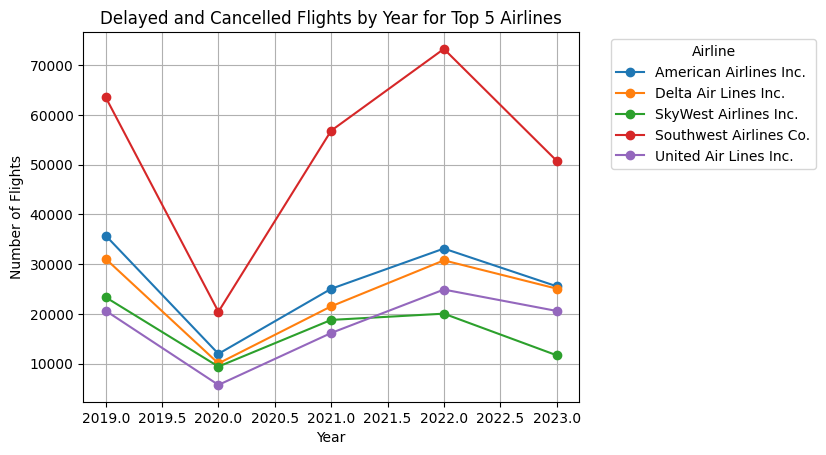

In [75]:
# Delayed and Cancelled Flights by Year for Top 5 Airlines

# Top 5 airlines based on flight frequency
top_airlines = filtered_df["AIRLINE"].value_counts().head(5).index.tolist()

# Filter the DataFrame for the top 5 airlines only
filtered_top_df = filtered_df[filtered_df["AIRLINE"].isin(top_airlines)]

# Convert FL_DATE to datetime format
filtered_top_df["FL_DATE"] = pd.to_datetime(filtered_top_df["FL_DATE"], format="%Y-%m-%d")

# Calculate the total number of delayed and cancelled flights by year for the top 5 airlines
yearly_counts = filtered_top_df.groupby([filtered_top_df["FL_DATE"].dt.year, "AIRLINE"]).size().unstack(fill_value=0)

# Filter the yearly counts for the specified years
specified_years = [2019, 2020, 2021, 2022, 2023]
yearly_counts_specified = yearly_counts.loc[specified_years]

print(yearly_counts_specified)

# Plotting a line graph Delayed and Cancelled Flights by Year for Top 5 Airline
yearly_counts_specified.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Flights')
plt.title('Delayed and Cancelled Flights by Year for Top 5 Airlines')
plt.legend(title='Airline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

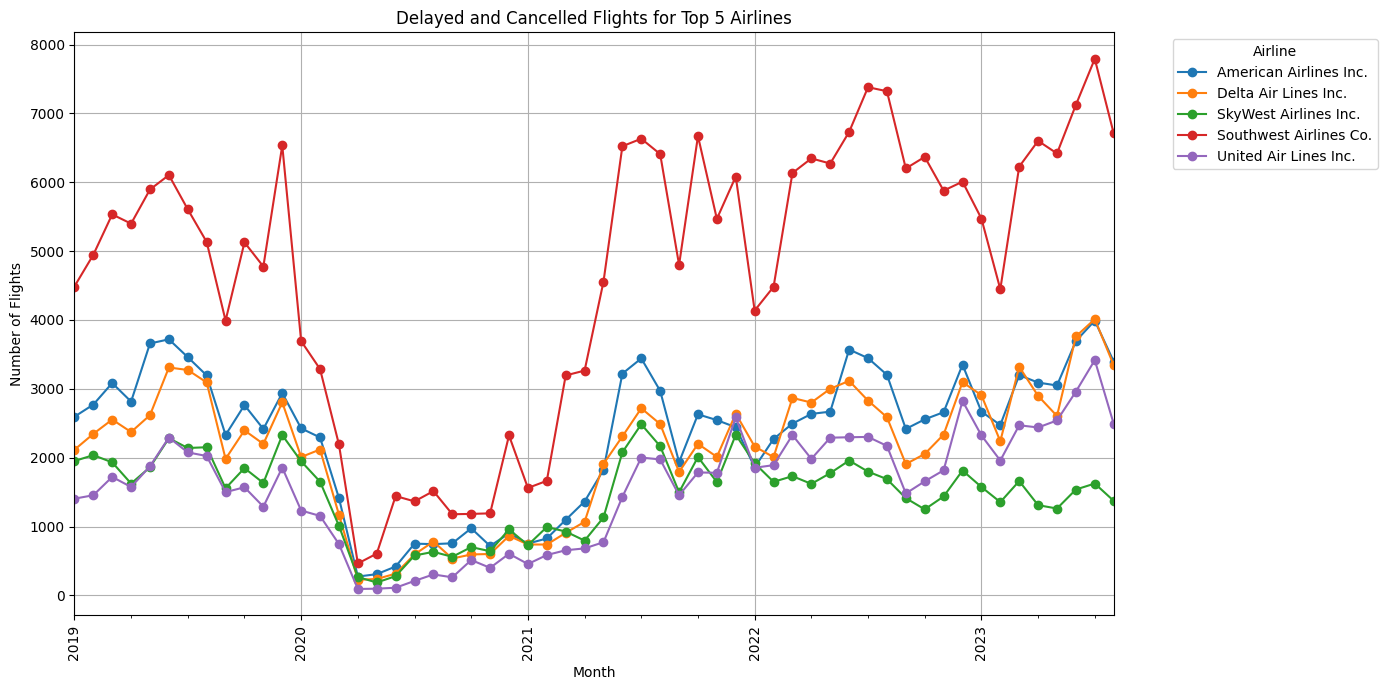

In [76]:
# Delayed and Cancelled Flights by Month for Top 5 Airlines

# Top 5 airlines based on flight frequency
top_airlines = filtered_df["AIRLINE"].value_counts().head(5).index.tolist()

# Filter the DataFrame for the top 5 airlines only
filtered_top_df = filtered_df[filtered_df["AIRLINE"].isin(top_airlines)]

# Convert FL_DATE to datetime format if not already
filtered_top_df["FL_DATE"] = pd.to_datetime(filtered_top_df["FL_DATE"], errors='coerce')

# Calculate the total number of delayed and cancelled flights by month for the top 5 airlines
monthly_counts = filtered_top_df.groupby([filtered_top_df["FL_DATE"].dt.to_period("M"), "AIRLINE"]).size().unstack(fill_value=0)

# Plotting line graph Delayed and Cancelled Flights for Top 5 Airlines
monthly_counts.plot(kind='line', marker='o', figsize=(14, 7)) 
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.title('Delayed and Cancelled Flights for Top 5 Airlines')
plt.legend(title='Airline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)  
plt.grid(True)
plt.tight_layout()  
plt.show()

Average Departure Delay per Airline: AIRLINE
Alaska Airlines Inc.                  29.234893
Allegiant Air                         49.350013
American Airlines Inc.                44.683390
Delta Air Lines Inc.                  36.086715
Endeavor Air Inc.                     50.396818
Envoy Air                             39.477321
ExpressJet Airlines LLC d/b/a aha!    68.207559
Frontier Airlines Inc.                50.431609
Hawaiian Airlines Inc.                21.898828
Horizon Air                           27.238614
JetBlue Airways                       53.996369
Mesa Airlines Inc.                    57.542687
PSA Airlines Inc.                     45.637909
Republic Airline                      49.370353
SkyWest Airlines Inc.                 54.308645
Southwest Airlines Co.                26.473832
Spirit Air Lines                      44.107778
United Air Lines Inc.                 41.172176
Name: DEP_DELAY, dtype: float64


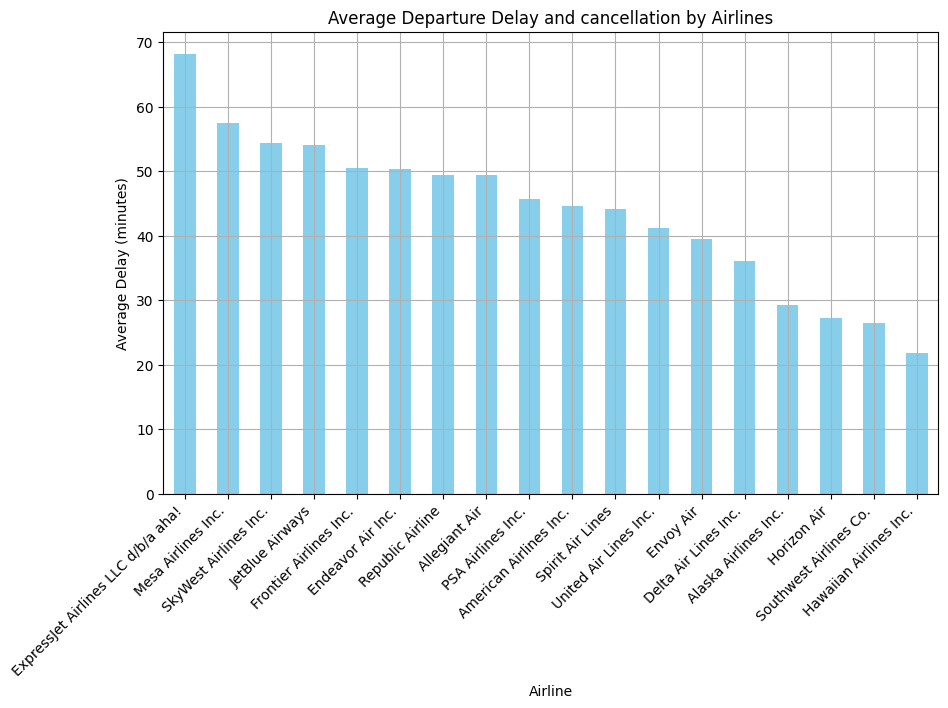

In [77]:
# Average departure delay and cancellation for each airline
avg_dep_delay = filtered_df.groupby('AIRLINE')['DEP_DELAY'].mean()

print("Average Departure Delay per Airline:", avg_dep_delay)

avg_dep_delay_sorted = avg_dep_delay.sort_values(ascending=False)

# Bar plot for average departure delays
avg_dep_delay_sorted.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Departure Delay and cancellation by Airlines')
plt.xlabel('Airline')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

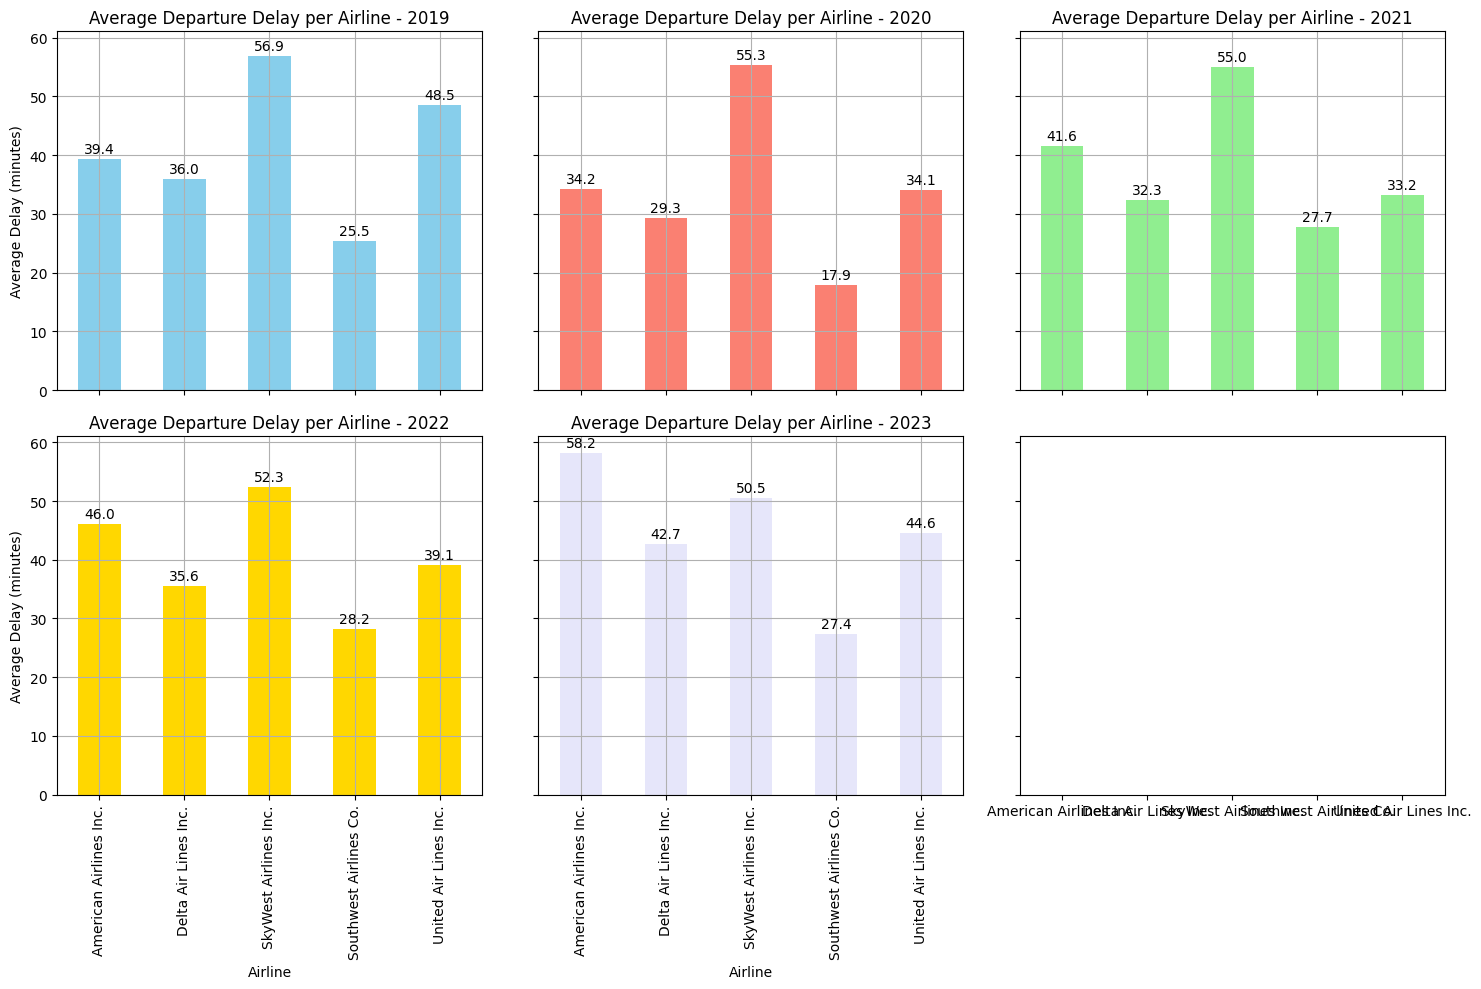

In [78]:
# Average departure delay for each airline per year

# Convert FL_DATE to datetime format
filtered_top_df["FL_DATE"] = pd.to_datetime(filtered_top_df["FL_DATE"], format="%Y-%m-%d")

# Extract year from FL_DATE and add as a new column "Year"
filtered_top_df["Year"] = filtered_top_df["FL_DATE"].dt.year

# Calculate average departure delay for each airline per year
avg_dep_delay_per_year = filtered_top_df[filtered_top_df["DEP_DELAY"] > 0].groupby(['Year', 'AIRLINE'])['DEP_DELAY'].mean()

# Plotting the results for each year
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex=True, sharey=True)

years = [2019, 2020, 2021, 2022, 2023,] 
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lavender',] 

for idx, year in enumerate(years):
    ax = axes[idx // 3, idx % 3]
    bars = avg_dep_delay_per_year.loc[year].plot(kind='bar', color=colors[idx], ax=ax)
    ax.set_title(f'Average Departure Delay per Airline - {year}')
    ax.set_xlabel('Airline')
    ax.set_ylabel('Average Delay (minutes)')
    ax.grid(True)

    # Annotate bars with their corresponding tick labels
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

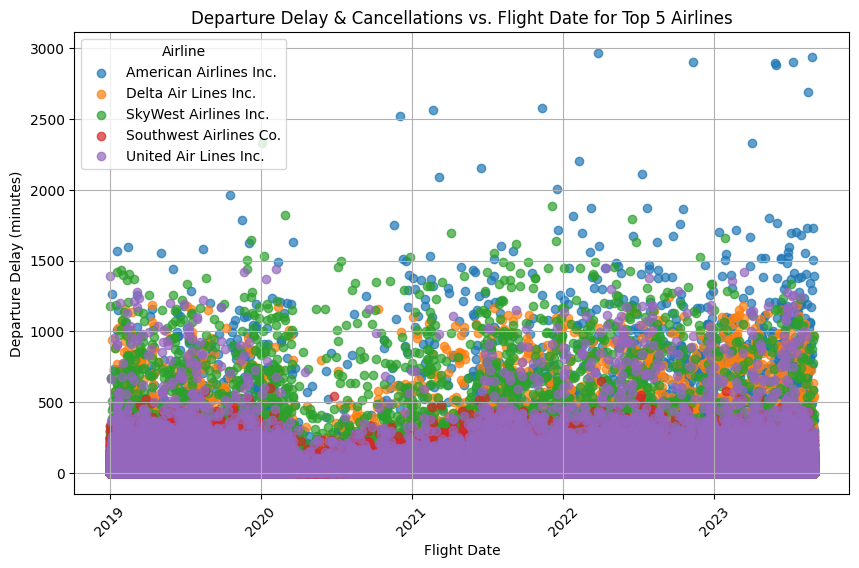

In [79]:
# Scatter Plot of Departure Delay and cancellations vs. Flight Date for Top 5 Airlines

# Convert 'FL_DATE' to datetime format
filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])

# Calculate the number of flights for each airline
airline_flights_count = filtered_df['AIRLINE'].value_counts()

# Select the top five airlines based on the number of flights
top_five_airlines = airline_flights_count.head(5).index

# Filter the data to include only the top five airlines
top_five_df = filtered_df[filtered_df['AIRLINE'].isin(top_five_airlines)]

# Group the data by airline
grouped_by_airline = top_five_df.groupby('AIRLINE')

# Create a scatter plot for each airline
plt.figure(figsize=(10, 6))
for airline, group_data in grouped_by_airline:
    plt.scatter(group_data['FL_DATE'], group_data['DEP_DELAY'], label=airline, alpha=0.7)

plt.title('Departure Delay & Cancellations vs. Flight Date for Top 5 Airlines')
plt.xlabel('Flight Date')
plt.ylabel('Departure Delay (minutes)')
plt.legend(title='Airline')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

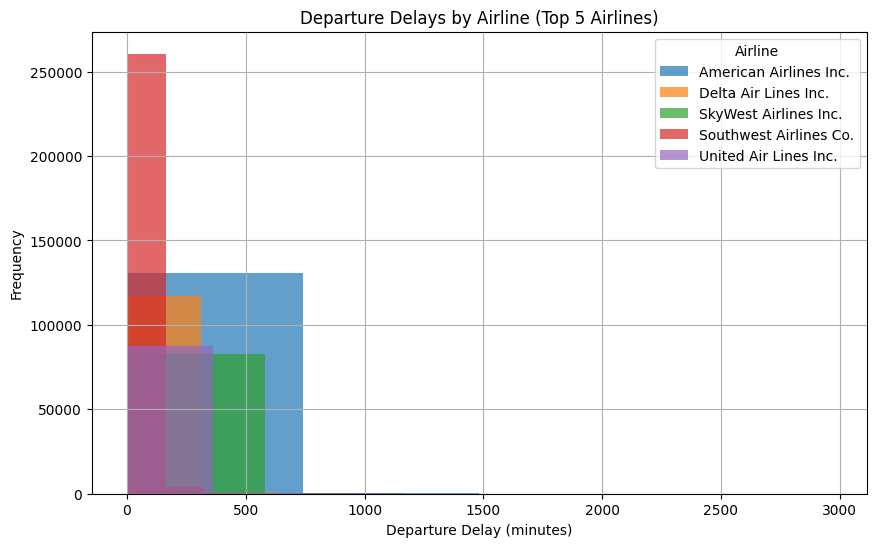

In [80]:
# Histogram of Departure Delays by Top 5 Airlines

# Number of flights for each airline
airline_flights_count = filtered_df['AIRLINE'].value_counts()

# Select the top five airlines based on the number of flights
top_five_airlines = airline_flights_count.head(5).index

# Filter the data to include only the top five airlines
top_five_df = filtered_df[filtered_df['AIRLINE'].isin(top_five_airlines)]

# Group the data by airline
grouped_by_airline = top_five_df.groupby('AIRLINE')

# Create a histogram for each airline
plt.figure(figsize=(10, 6))
for airline, group_data in grouped_by_airline:
    plt.hist(group_data['DEP_DELAY'], bins=4, alpha=0.7, label=airline)

plt.title('Departure Delays by Airline (Top 5 Airlines)')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.legend(title='Airline')
plt.grid(True)
plt.show()

In [81]:
# Mean, median, and mode for number of departure delays of the Top 5 airline (Includes Cancellations)

top_delayed_airlines = filtered_df[filtered_df["DEP_DELAY"] > 0]["AIRLINE"].value_counts().head()

mean_delay = np.mean(top_delayed_airlines)
median_delay = np.median(top_delayed_airlines)
modes_delay = top_delayed_airlines.mode()

print("Mean departure delay for top 5 airlines:", mean_delay)
print("Median departure delay for top 5 airlines:", median_delay)
print("Mode departure delay for top 5 airlines:", modes_delay)

Mean departure delay for top 5 airlines: 137248.2
Median departure delay for top 5 airlines: 118515.0
Mode departure delay for top 5 airlines: 0     83332
1     88055
2    118515
3    131490
4    264849
Name: count, dtype: int64


In [82]:
# Mean median, and mode of departure delay in minutes for top 5 airlines (Includeds Cancellations )
top_delayed_airlines = filtered_df[filtered_df["DEP_DELAY"] > 0]["AIRLINE"].value_counts().head(5)


mean_delay = np.mean(filtered_df[(filtered_df["DEP_DELAY"] > 0) & (filtered_df["AIRLINE"].isin(top_delayed_airlines.index))]["DEP_DELAY"])
median_delay = np.median(filtered_df[(filtered_df["DEP_DELAY"] > 0) & (filtered_df["AIRLINE"].isin(top_delayed_airlines.index))]["DEP_DELAY"])
modes_delay = filtered_df[(filtered_df["DEP_DELAY"] > 0) & (filtered_df["AIRLINE"].isin(top_delayed_airlines.index))]["DEP_DELAY"].mode()

print("Mean departure delay for top 5 airlines (minutes):", mean_delay)
print("Median departure delay for top 5 airlines (minutes):", median_delay)
print("Mode departure delay for top 5 airlines (minutes):", modes_delay)


Mean departure delay for top 5 airlines (minutes): 36.88918033169105
Median departure delay for top 5 airlines (minutes): 15.0
Mode departure delay for top 5 airlines (minutes): 0    1.0
Name: DEP_DELAY, dtype: float64


In [83]:
#Top 5 cancelled by Airline
cancelled_flights_df = simplified_flight_df[simplified_flight_df["CANCELLED"] == 1]
top_cancellations = cancelled_flights_df["AIRLINE"].value_counts().head(5)
top_cancellations

AIRLINE
Southwest Airlines Co.    19465
American Airlines Inc.    10907
SkyWest Airlines Inc.      7745
Delta Air Lines Inc.       5982
United Air Lines Inc.      5536
Name: count, dtype: int64

In [84]:
# Mean, median, and mode for cancellations for top 5 airlines

cancelled_flights_count = simplified_flight_df[(simplified_flight_df["CANCELLED"] == 1) & (simplified_flight_df["AIRLINE"].isin(top_delayed_airlines.index))]["AIRLINE"].value_counts()

mean_cancelled = np.mean(cancelled_flights_count)
median_cancelled = np.median(cancelled_flights_count)
modes_cancelled = cancelled_flights_count.mode()

print("Mean cancellation count for top 5 airlines:", mean_cancelled)
print("Median cancellation count for top 5 airlines:", median_cancelled)
print("Mode cancellation count for top 5 airlines:", modes_cancelled)

Mean cancellation count for top 5 airlines: 9927.0
Median cancellation count for top 5 airlines: 7745.0
Mode cancellation count for top 5 airlines: 0     5536
1     5982
2     7745
3    10907
4    19465
Name: count, dtype: int64


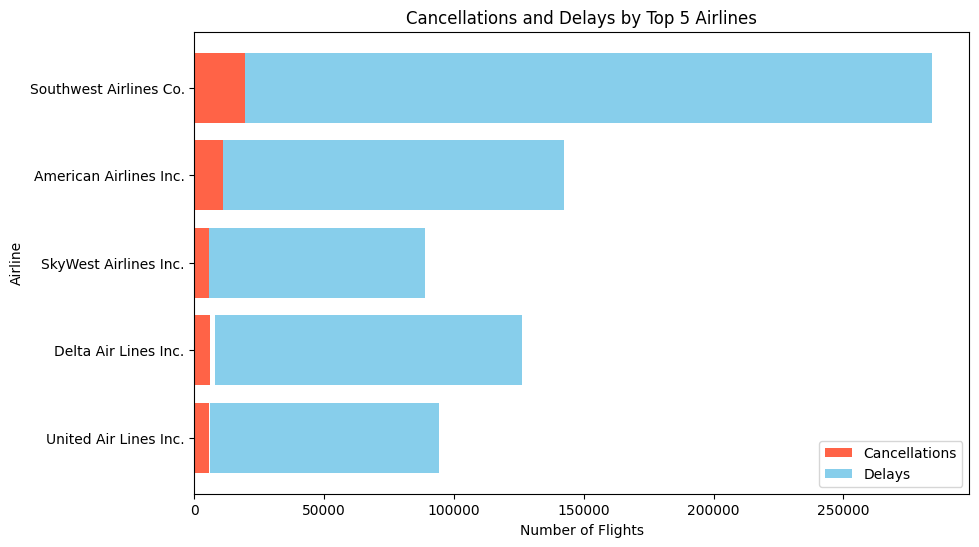

In [85]:
# Stacked bar chart of cancellations and delays by top 5 airlines

# Consolidated dataframe
filtered_df = flight_data_df.loc[(flight_data_df["DEP_DELAY"] > 0), ["FL_DATE", "AIRLINE", "ORIGIN_CITY", "DEST_CITY", "DEP_DELAY", "CANCELLED"]]
filtered_df["ORIGIN_STATE"] = filtered_df["ORIGIN_CITY"].str.rsplit(',').str[-1]

# Cancellation only dataframe
cancelled_flights_df = simplified_flight_df[simplified_flight_df["CANCELLED"] == 1]

# Top 5 cancelled by Airline
top_cancellations = cancelled_flights_df["AIRLINE"].value_counts().head(5)

# Top 5 delayed by Airline
top_delays = filtered_df["AIRLINE"].value_counts().head(5)

# Create figure for combined plots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting number of cancellations and delays by top 5 airlines (stacked bar chart)
ax.barh(top_cancellations.index, top_cancellations.values, color='tomato', label='Cancellations')
ax.barh(top_delays.index, top_delays.values, color='skyblue', left=top_cancellations.values, label='Delays')
ax.set_xlabel('Number of Flights')
ax.set_ylabel('Airline')
ax.set_title('Cancellations and Delays by Top 5 Airlines')
ax.legend()
ax.invert_yaxis()
plt.show()